In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime


In [2]:
tsla = yf.download('TSLA', start='2015-01-01', end='2025-07-31')['Close'].asfreq('B').fillna(method='ffill')
bnd = yf.download('BND', start='2015-01-01', end='2025-07-31')['Close'].asfreq('B').fillna(method='ffill')
spy = yf.download('SPY', start='2015-01-01', end='2025-07-31')['Close'].asfreq('B').fillna(method='ffill')


C:\Users\HP\AppData\Local\Temp\ipykernel_4948\784892927.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tsla = yf.download('TSLA', start='2015-01-01', end='2025-07-31')['Close'].asfreq('B').fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
C:\Users\HP\AppData\Local\Temp\ipykernel_4948\784892927.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bnd = yf.download('BND', start='2015-01-01', end='2025-07-31')['Close'].asfreq('B').fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
C:\Users\HP\AppData\Local\Temp\ipykernel_4948\784892927.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start='2015-01-01', end='2025-07-31')['Close'].asfreq('B').fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed


In [4]:
start_backtest = pd.Timestamp('2024-08-01')
end_backtest = pd.Timestamp('2025-07-31')

tsla.name = 'TSLA'
bnd.name = 'BND'
spy.name = 'SPY'

prices = pd.concat([tsla, bnd, spy], axis=1).loc[start_backtest:end_backtest].dropna()
returns = prices.pct_change().dropna()


In [7]:
opt_df = pd.read_csv('../data/task4_optimal_portfolios_summary.csv', index_col=0)
if 'Max_Sharpe' in opt_df.index:
    w_tsla = float(opt_df.loc['Max_Sharpe','w_TSLA'])
    w_bnd = float(opt_df.loc['Max_Sharpe','w_BND'])
    w_spy = float(opt_df.loc['Max_Sharpe','w_SPY'])
else:
    row = opt_df.iloc[0]
    w_tsla = float(row['w_TSLA'])
    w_bnd = float(row['w_BND'])
    w_spy = float(row['w_SPY'])
weights_hold = np.array([w_tsla, w_bnd, w_spy])
weights_hold = weights_hold / weights_hold.sum()
weights_hold


array([9.47587326e-05, 4.27092533e-01, 5.72812708e-01])

In [8]:
bench_weights = np.array([0.0, 0.4, 0.6])


In [9]:
daily_returns = returns.copy()
daily_returns = daily_returns.dropna()


In [10]:
port_ret_hold = daily_returns.dot(weights_hold)
bench_ret = daily_returns.dot(bench_weights)
monthly_index = pd.date_range(start=start_backtest, end=end_backtest, freq='BM')
port_values = pd.Series(index=daily_returns.index, dtype=float)
cash = 1.0
shares = np.zeros(3)
first_day = daily_returns.index[0]
prices_first = prices.loc[first_day].values
shares = (cash * weights_hold) / prices_first
pv = (shares * prices.loc[first_day]).sum()
port_values.iloc[0] = pv
for i, day in enumerate(daily_returns.index[1:], start=1):
    prices_day = prices.loc[day].values
    pv = (shares * prices.loc[day]).sum()
    if day in monthly_index:
        pv_pre = pv
        total_value = pv
        shares = (total_value * weights_hold) / prices_day
    port_values.iloc[i] = pv
port_cum_hold = port_values / port_values.iloc[0]


In [11]:
bench_values = pd.Series(index=daily_returns.index, dtype=float)
cash = 1.0
shares_b = np.zeros(3)
shares_b = (cash * bench_weights) / prices.loc[first_day].values
for i, day in enumerate(daily_returns.index):
    bench_values.iloc[i] = (shares_b * prices.loc[day]).sum()
bench_cum = bench_values / bench_values.iloc[0]


In [12]:
total_return_strategy = port_cum_hold.iloc[-1] - 1.0
annualized_return_strategy = (port_cum_hold.iloc[-1]) ** (252/len(port_cum_hold)) - 1
vol_strategy = daily_returns.dot(weights_hold).std() * np.sqrt(252)
sharpe_strategy = annualized_return_strategy / vol_strategy if vol_strategy!=0 else np.nan
total_return_bench = bench_cum.iloc[-1] - 1.0
annualized_return_bench = (bench_cum.iloc[-1]) ** (252/len(bench_cum)) - 1
vol_bench = bench_ret.std() * np.sqrt(252)
sharpe_bench = annualized_return_bench / vol_bench if vol_bench!=0 else np.nan


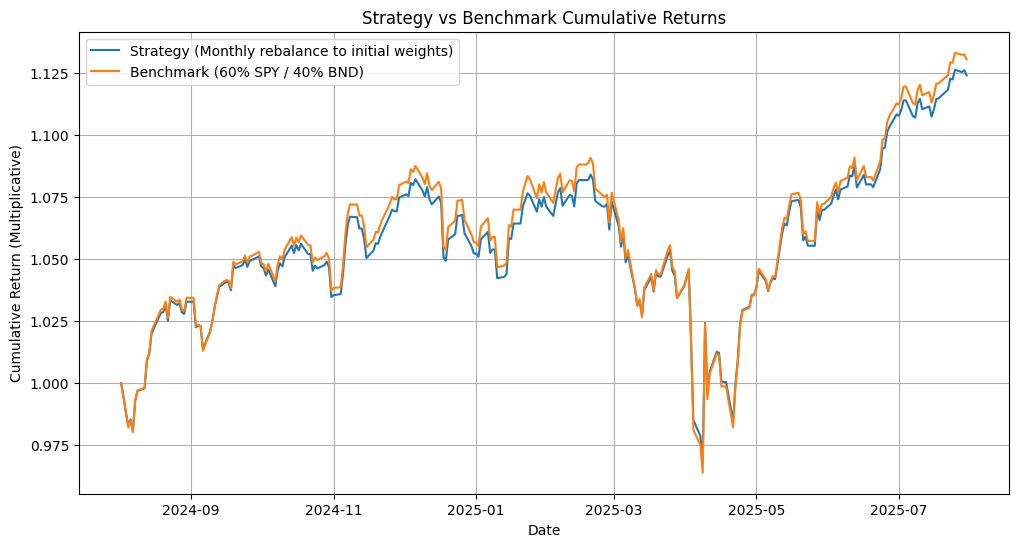

In [13]:
plt.figure(figsize=(12,6))
plt.plot(port_cum_hold.index, port_cum_hold.values, label='Strategy (Monthly rebalance to initial weights)')
plt.plot(bench_cum.index, bench_cum.values, label='Benchmark (60% SPY / 40% BND)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Multiplicative)')
plt.title('Strategy vs Benchmark Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
results_summary = pd.DataFrame({
    'Metric': ['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio'],
    'Strategy': [total_return_strategy, annualized_return_strategy, vol_strategy, sharpe_strategy],
    'Benchmark': [total_return_bench, annualized_return_bench, vol_bench, sharpe_bench]
})
results_summary['Strategy'] = results_summary['Strategy'].apply(lambda x: float(x))
results_summary['Benchmark'] = results_summary['Benchmark'].apply(lambda x: float(x))
results_summary


,Metric,Strategy,Benchmark
0,Total Return,0.124047,0.130544
1,Annualized Return,0.120500,0.126801
2,Annualized Volatility,0.116869,0.121806
3,Sharpe Ratio,1.031067,1.041010


In [15]:
print("Strategy Weights (TSLA, BND, SPY):", np.round(weights_hold,6))
print("Strategy Total Return:", f"{total_return_strategy*100:.2f}%")
print("Strategy Annualized Return:", f"{annualized_return_strategy*100:.2f}%")
print("Strategy Volatility (ann):", f"{vol_strategy*100:.2f}%")
print("Strategy Sharpe Ratio:", f"{sharpe_strategy:.4f}")
print("")
print("Benchmark Total Return:", f"{total_return_bench*100:.2f}%")
print("Benchmark Annualized Return:", f"{annualized_return_bench*100:.2f}%")
print("Benchmark Volatility (ann):", f"{vol_bench*100:.2f}%")
print("Benchmark Sharpe Ratio:", f"{sharpe_bench:.4f}")


Strategy Weights (TSLA, BND, SPY): [9.50000e-05 4.27093e-01 5.72813e-01]
Strategy Total Return: 12.40%
Strategy Annualized Return: 12.05%
Strategy Volatility (ann): 11.69%
Strategy Sharpe Ratio: 1.0311

Benchmark Total Return: 13.05%
Benchmark Annualized Return: 12.68%
Benchmark Volatility (ann): 12.18%
Benchmark Sharpe Ratio: 1.0410


In [16]:
out = {
    'strategy_weights': weights_hold.tolist(),
    'strategy_total_return': total_return_strategy,
    'strategy_annual_return': annualized_return_strategy,
    'strategy_volatility': vol_strategy,
    'strategy_sharpe': sharpe_strategy,
    'benchmark_weights': bench_weights.tolist(),
    'benchmark_total_return': total_return_bench,
    'benchmark_annual_return': annualized_return_bench,
    'benchmark_volatility': vol_bench,
    'benchmark_sharpe': sharpe_bench
}
pd.Series(out).to_csv('task5_backtest_results.csv')
print("Saved task5_backtest_results.csv")


Saved task5_backtest_results.csv
